
# Part 2: Sentiment Analysis — Google Play Store User Reviews

- Analyze the distribution of sentiments in the reviews dataset using raw data and a specialized sentiment model (VADER)  
- Compare LLM-based sentiment analysis on a random sample of reviews  
- Provide insights in the **Application catalog / IT landscape** context

---
**Notes:**
- CSVs files are under `data/input` as in earlier notebooks.

In [1]:
import os
import tqdm 
import dotenv
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, List, Callable, Union, Literal
from pydantic import BaseModel, Field
from langchain.prompts import PromptTemplate
from langchain_ollama import ChatOllama
from langchain_openai import ChatOpenAI
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

dotenv.find_dotenv()    # Load environment variables from .env file

'/mnt/c/Users/Gaurav/Desktop/Work/Interview/SAP/Assignment/SentimentAnalysis/.env'

### Data preprocessing

In [ ]:
# Load the dataset
reviews = pd.read_csv("data/input/googleplaystore_user_reviews.csv")

# Convert column names to lowercase and remove spaces
reviews.columns = [c.strip().lower().replace(" ", "_") for c in reviews.columns]

# Drop rows with missing 'translated_review' values and drop duplicates
reviews_clean = reviews.dropna(subset=['translated_review']).copy()
reviews_clean.reset_index(drop=True, inplace=True)  # Reset index to avoid issues with dropped rows
reviews_clean.drop_duplicates(subset='translated_review', inplace=True)

# Convert the sentiment to lower case
reviews_clean['sentiment'] = reviews_clean['sentiment'].apply(lambda x: x.lower() if not pd.isna(x) else x)

# Filter reviews without sentiments
# apps_clean.dropna(inplace=True) 
reviews_clean = reviews_clean[~reviews_clean.sentiment.isna()]

# View the first few rows of the cleaned dataset
reviews_clean.head()

,app,translated_review,sentiment,sentiment_polarity,sentiment_subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,positive,0.25,0.288462
2,10 Best Foods for You,Works great especially going grocery store,positive,0.40,0.875000
3,10 Best Foods for You,Best idea us,positive,1.00,0.300000
4,10 Best Foods for You,Best way,positive,1.00,0.300000


In [3]:
reviews_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27994 entries, 0 to 37426
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   app                     27994 non-null  object 
 1   translated_review       27994 non-null  object 
 2   sentiment               27994 non-null  object 
 3   sentiment_polarity      27994 non-null  float64
 4   sentiment_subjectivity  27994 non-null  float64
dtypes: float64(2), object(3)
memory usage: 1.3+ MB


In [4]:
reviews_clean.groupby(['app']).size()

app
10 Best Foods for You                                 95
104 找工作 - 找工作 找打工 找兼職 履歷健檢 履歷診療室                      35
11st                                                  36
1800 Contacts - Lens Store                            39
1LINE – One Line with One Touch                       35
                                                      ..
Hotels.com: Book Hotel Rooms & Find Vacation Deals    39
Hotspot Shield Free VPN Proxy & Wi-Fi Security        20
Hotstar                                               30
Hotwire Hotel & Car Rental App                        31
Housing-Real Estate & Property                        20
Length: 863, dtype: int64

### Data visualization and Analysis

In [5]:
# Filter review data to include at-least 50 reviews per app
min_reviews = 50
reviews_filter = (reviews_clean.groupby(['app']).size()   # Group by app and count the number of reviews
                  [reviews_clean.groupby(['app']).size() > min_reviews]   # Filter to include only apps with at least min_reviews number of reviews
                  .reset_index())   # Reset index to convert the Series back into a DataFrame

# Apply filter to dataframe
reviews_filtered = reviews_clean[reviews_clean.app.isin(reviews_filter.app)]

# view
reviews_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6183 entries, 0 to 37202
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   app                     6183 non-null   object 
 1   translated_review       6183 non-null   object 
 2   sentiment               6183 non-null   object 
 3   sentiment_polarity      6183 non-null   float64
 4   sentiment_subjectivity  6183 non-null   float64
dtypes: float64(2), object(3)
memory usage: 289.8+ KB


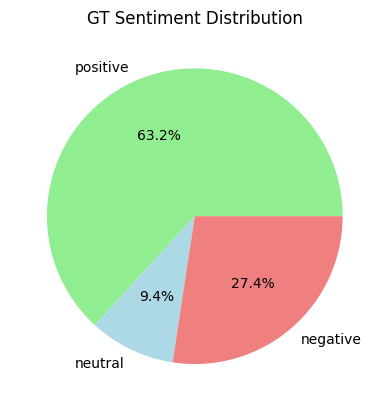

In [6]:
# Visualize the Distribution Pie plot
sen_labels=['positive', 'neutral', 'negative']
plot_df_gt = reviews_filtered['sentiment'].value_counts(normalize=True)
plt.pie([plot_df_gt.get(s,0) for s in sen_labels], autopct='%1.1f%%', labels=sen_labels, colors=['lightgreen', 'lightblue', 'lightcoral'])
plt.title("GT Sentiment Distribution")
plt.show()

--------Top 5 positive sentiment Apps-----------
app
ColorNote Notepad Notes         91
Calorie Counter - Macros        87
8fit Workouts & Meal Planner    82
Calorie Counter - MyNetDiary    81
10 Best Foods for You           79
dtype: int64
--------Top 5 Negative sentiment Apps-----------
app
Angry Birds Classic      59
Be A Legend: Soccer      59
Facebook                 59
Cooking Fever            57
Candy Crush Soda Saga    50
dtype: int64


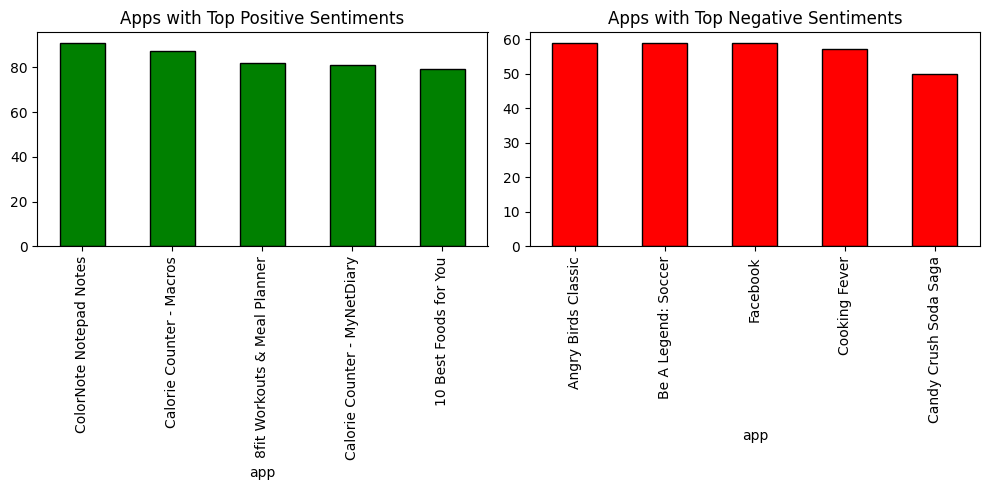

In [7]:
# Prepare dataset for plotting
apps_pos_sentiments = reviews_filtered[reviews_filtered.sentiment == 'positive'].groupby(['app']).size().sort_values(ascending=False)
app_neu_sentiments= reviews_filtered[reviews_filtered.sentiment == 'neutral'].groupby(['app']).size().sort_values(ascending=False)
app_neg_sentiments = reviews_filtered[reviews_filtered.sentiment == 'negative'].groupby(['app']).size().sort_values(ascending=False)

# Check top 5 apps with maximum positive and negative sentiment
print(
    "--------Top 5 positive sentiment Apps-----------",
    apps_pos_sentiments[:5], 
    "--------Top 5 Negative sentiment Apps-----------", 
    app_neg_sentiments[:5], 
    sep="\n"
    )

# Plot the top 5 apps with positive and negative sentiments
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
apps_pos_sentiments[:5].plot.bar(x='app', y='count', color='green', edgecolor='black', ax=axs[0], title='Apps with Top Positive Sentiments')
# axs[0].tick_params(axis='x', labelrotation=45) # Rotate x-axis labels by 45 degrees
app_neg_sentiments[:5].plot.bar(x='app', y='count', color='red', edgecolor='black', ax=axs[1], title='Apps with Top Negative Sentiments')
# axs[1].tick_params(axis='x', labelrotation=45) # Rotate x-axis labels by 45 degrees
fig.tight_layout() # Layout so plots do not overlap



Observations:
* Distribution of sentiments is balanced with a slight preference towards Positive sentiment followed by Negative and Neutral. 
* Positive Sentiments: The top positive sentiment apps are mostly games and productivity apps, indicating that users have a strong affinity for these types of content.
* Negative Sentiments: The top negative sentiment apps have less reviews than apps with positive sentiments, indicating that these apps are not as popular or well-received by users.  User's reviews suggests that they may be experiencing frustration or dissatisfaction with certain game mechanics or features.

Conclusion:

Users tend to have a positive sentiment towards apps that provide entertainment and productivity value, while those that fail to meet user expectations tend to receive negative reviews. These insights can inform app developers and marketers to create more engaging and satisfying experiences for users.

### Sentiment analysis
1. Using VADER Score
2. Using LLM

#### 1. Using VADER Score

In [8]:
# Download the VADER lexicon
# nltk.download('vader_lexicon')

# Create object of Sentiment analyzer
sid = SentimentIntensityAnalyzer()

sid.polarity_scores(str(x)) is from the vaderSentiment library (part of the NLTK toolkit) that calculates the sentiment scores of a given text.
It returns a dictionary with four keys:
* 'neg': The proportion of text that falls in the negative category.
* 'neu': The proportion of text that falls in the neutral category.
* 'pos': The proportion of text that falls in the positive category.
* 'compound': A score that calculates the sum of all lexicon ratings which have been normalized between -1 and +1. 

* *sentiment_polarity* weighted sum of all sentiment-bearing words in the text. However, *compound* the overall sentiment of the text by aggregating the lexicon ratings for each word and normalized between +1 and -1

In [9]:
# Compute sentiment scores and save in a new column
reviews_clean['vader_scores'] = reviews_clean['translated_review'].apply(lambda x: sid.polarity_scores(str(x)))
reviews_clean.head()

,app,translated_review,sentiment,sentiment_polarity,sentiment_subjectivity,vader_scores
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,positive,1.00,0.533333,"{'neg': 0.0, 'neu': 0.466, 'pos': 0.534, 'comp..."
1,10 Best Foods for You,This help eating healthy exercise regular basis,positive,0.25,0.288462,"{'neg': 0.0, 'neu': 0.481, 'pos': 0.519, 'comp..."
2,10 Best Foods for You,Works great especially going grocery store,positive,0.40,0.875000,"{'neg': 0.0, 'neu': 0.549, 'pos': 0.451, 'comp..."
3,10 Best Foods for You,Best idea us,positive,1.00,0.300000,"{'neg': 0.0, 'neu': 0.323, 'pos': 0.677, 'comp..."
4,10 Best Foods for You,Best way,positive,1.00,0.300000,"{'neg': 0.0, 'neu': 0.192, 'pos': 0.808, 'comp..."


In [10]:
# Remove existing 'vader_scores' column, split 'vadar_scores' column into 4 separate column and concatenate them to the DataFrame
reviews_clean = pd.concat([reviews_clean.drop(['vader_scores'], axis=1), pd.json_normalize(reviews_clean['vader_scores'])], axis=1)
reviews_clean.head(2)

,app,translated_review,sentiment,sentiment_polarity,sentiment_subjectivity,neg,neu,pos,compound
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,positive,1.00,0.533333,0.0,0.466,0.534,0.9531
1,10 Best Foods for You,This help eating healthy exercise regular basis,positive,0.25,0.288462,0.0,0.481,0.519,0.6597


In [11]:
# Categorize sentiment
def vader_label(compound):
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply the sentiment label to each compound score
reviews_clean['vader_sentiment'] = reviews_clean['compound'].apply(vader_label)

In [12]:
reviews_clean.head(2)

,app,translated_review,sentiment,sentiment_polarity,sentiment_subjectivity,neg,neu,pos,compound,vader_sentiment
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,positive,1.00,0.533333,0.0,0.466,0.534,0.9531,positive
1,10 Best Foods for You,This help eating healthy exercise regular basis,positive,0.25,0.288462,0.0,0.481,0.519,0.6597,positive


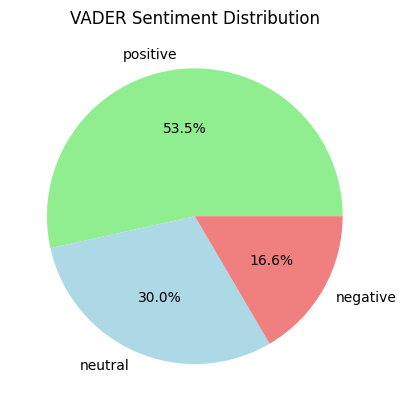

In [13]:
sentiment_cls = ('positive','neutral','negative')

# Visualize the Distribution Pie plot
plot_df = reviews_clean['vader_sentiment'].value_counts(normalize=True)
# reviews_clean['vader_sentiment'].value_counts(normalize=True, sort=False).plot.pie(
#     autopct='%1.1f%%', colors=['lightgreen','lightcoral','lightblue'], title="VADER Sentiment Distribution"
# )
plt.pie([plot_df.get(s,0) for s in sentiment_cls], autopct='%1.1f%%', labels=sentiment_cls, colors=['lightgreen', 'lightblue', 'lightcoral'])
plt.title("VADER Sentiment Distribution")
plt.show()

--------Top 5 positive sentiment Apps-----------
app
Episode - Choose Your Story       105
Facebook                           95
Calorie Counter - Macros           82
Calorie Counter & Diet Tracker     79
10 Best Foods for You              79
Name: count, dtype: int64
--------Top 5 Negative sentiment Apps-----------
app
DEAD TARGET: FPS Zombie Apocalypse Survival Games    34
Avakin Life - 3D virtual world                       34
Build a Bridge!                                      33
Cut the Rope 2                                       32
Angry Birds Classic                                  31
Name: count, dtype: int64


<Axes: title={'center': 'Apps with Top Negative Sentiments'}, xlabel='app'>

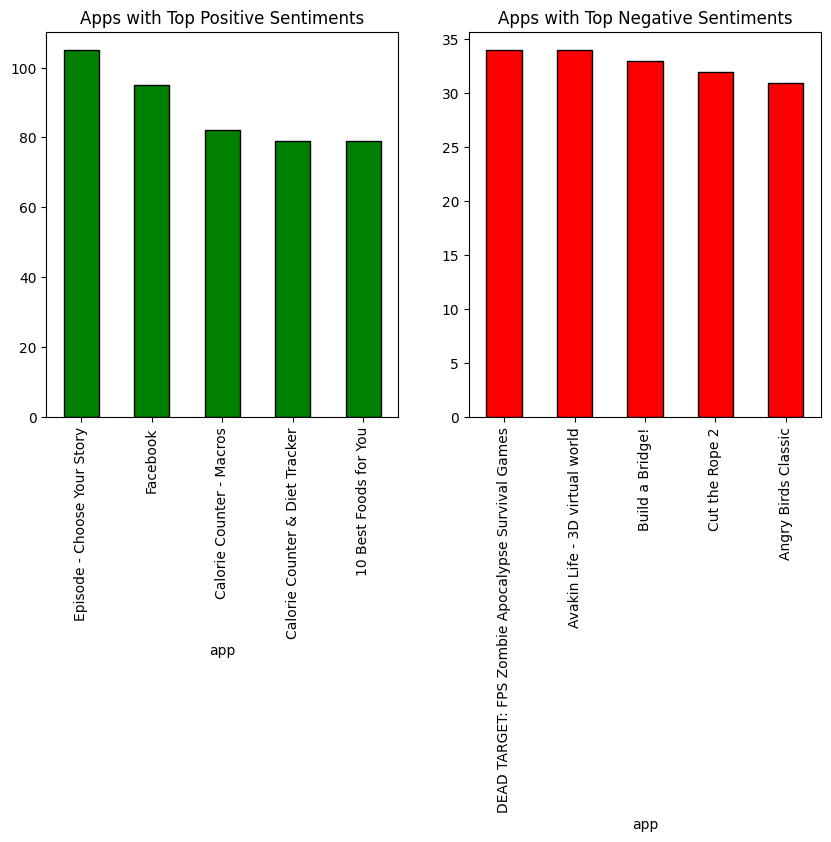

In [14]:
# Top 5 Apps with maximum positive sentiment
app_positive_sentiment = reviews_clean[reviews_clean['vader_sentiment'] == 'positive']['app'].value_counts()
app_negative_sentiment = reviews_clean[reviews_clean['vader_sentiment'] == 'negative']['app'].value_counts()

# Check top 5 apps with maximum positive and negative sentiment
print(
    "--------Top 5 positive sentiment Apps-----------",
    app_positive_sentiment[:5], 
    "--------Top 5 Negative sentiment Apps-----------", 
    app_negative_sentiment[:5], 
    sep="\n"
    )

# Plot the top 5 apps with positive and negative sentiments
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
app_positive_sentiment[:5].plot.bar(x='app', y='count', color='green', edgecolor='black', ax=axs[0], title='Apps with Top Positive Sentiments')
# axs[0].tick_params(axis='x', labelrotation=45) # Rotate x-axis labels by 45 degrees
app_negative_sentiment[:5].plot.bar(x='app', y='count', color='red', edgecolor='black', ax=axs[1], title='Apps with Top Negative Sentiments')
# axs[1].tick_params(axis='x', labelrotation=45) # Rotate x-axis labels by 45 degrees
# fig.tight_layout() # Layout so plots do not overlap


**Findings:**  
- Majority of reviews are positive.  
- Neutral reviews form a smaller fraction.  
- Negative reviews are a minority but crucial for app assessment.

**IT context:**  
- Positive → apps performing well.  
- Negative → candidates for remediation, replacement, or decommissioning.  
- Neutral → generic feedback, may need further analysis.  


#### 2. using LLM (LangChain + structured output schema)

Setup function

In [15]:
class SentimentSchema(BaseModel):
    """Schema for sentiment analysis"""

    sentiment: Literal["positive", "neutral", "negative"]  = Field(..., description="Sentiment of the review")
    score: float = Field(..., description="Sentiment score (0-1)")
    comments: str = Field(..., description="Comments")

# Function to classify with LLM
def sentiment_classification_ollama(llm, sample_reviews):
    # llm with structured output
    llm = llm.with_structured_output(SentimentSchema)

    # Create prompt for sentiment analysis
    template = """
    You are an expert analysis of customer reviews. 
    Your task is to analyze the sentiment of a given review and provide a sentiment, score and small comment

    Review:
    {review}
    """
    prompt = PromptTemplate(
        input_variables=["review"], 
        template=template, 
        validate_template=True
    )

    # Create sentiment analysis chain
    llm_chain = prompt | llm

    labels = [] 
    for _, row in tqdm.tqdm(sample_reviews.iterrows(), desc="Classifying sentiments"):
        # Extract review text
        review = row.translated_review
                
        # Invoking the llm chain
        response = llm_chain.invoke({
            "review": review
            })
        # Appending sentiment to the labels list
        labels.append(response.sentiment)
    return labels

Invoke the LLM for generating sentiments

In [16]:
# Sample dataset
max_samples = 50
sample_reviews = reviews_clean.sample(max_samples, random_state=42)

# Create LLM
# llm = ChatOpenAI(
#     model="gpt-4o-mini", 
#     max_retries=2, 
#     temperature=0.0
#     )
llm = ChatOllama(
    base_url="localhost:11434",
    model="llama3.1:8b",
    temperature=0.0
)

# Predict sentiments using LLM
llm_labels = sentiment_classification_ollama(llm, sample_reviews)

# Add new column of LLM sentiment prediction
sample_reviews['LLM_sentiment'] = llm_labels

Classifying sentiments: 0it [00:00, ?it/s]

Classifying sentiments: 50it [01:12,  1.45s/it]


In [17]:
(
    sample_reviews['sentiment'].value_counts(normalize=True, sort=False).round(2), 
    sample_reviews['vader_sentiment'].value_counts(normalize=True, sort=False).round(2), 
    sample_reviews['LLM_sentiment'].value_counts(normalize=True, sort=False).round(2)
    )

(sentiment
 positive    0.68
 neutral     0.16
 negative    0.16
 Name: proportion, dtype: float64,
 vader_sentiment
 neutral     0.24
 positive    0.54
 negative    0.22
 Name: proportion, dtype: float64,
 LLM_sentiment
 neutral     0.22
 positive    0.40
 negative    0.38
 Name: proportion, dtype: float64)

### Sentiment Evaluation (VADER vs LLM)

In [18]:
# # Visualize the Distribution Pie plot
# plot_df = sample_reviews['LLM_sentiment'].value_counts(normalize=True)
# plt.pie([plot_df.get(s,0) for s in ('positive','neutral','negative')], autopct='%1.1f%%', labels=['Positive', 'Neutral', 'Negative'], colors=['lightgreen', 'lightblue', 'lightcoral'])
# plt.title("LLM Sentiment Distribution")
# plt.show()

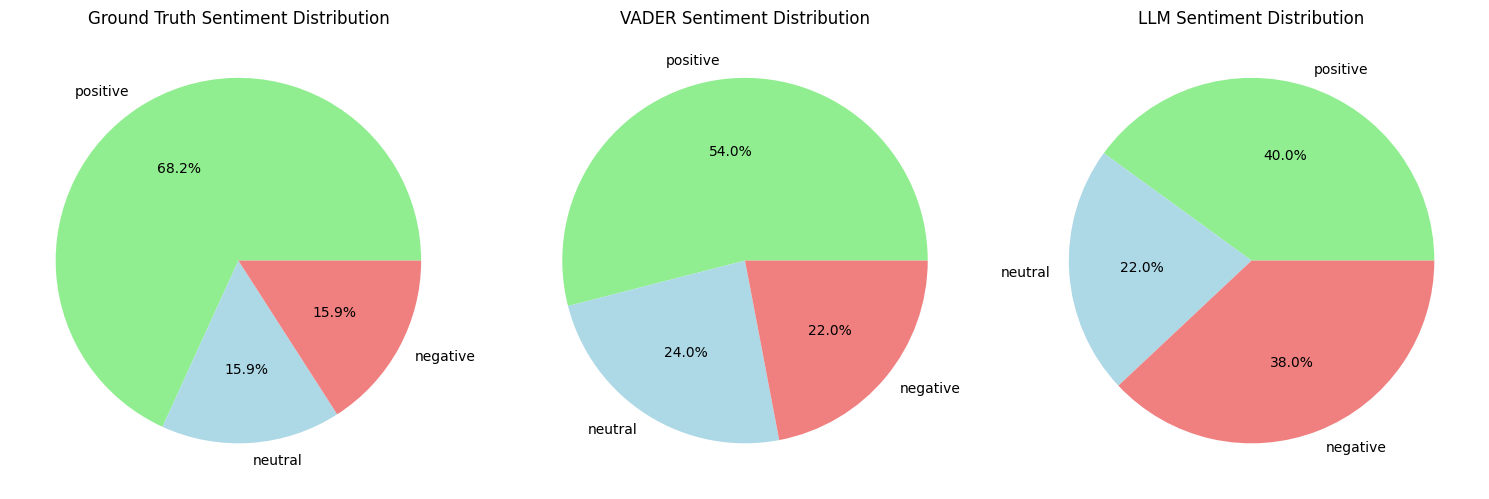

In [19]:
# Visualize the Distribution Pie plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot LLM sentiment distribution on first subplot
plot_df_gt = sample_reviews['sentiment'].value_counts(normalize=True)
axs[0].pie([plot_df_gt.get(s,0) for s in sentiment_cls], labels=sentiment_cls, colors=['lightgreen', 'lightblue', 'lightcoral'], autopct='%1.1f%%')
axs[0].set_title("Ground Truth Sentiment Distribution")

# # Plot Vader sentiment distribution on second subplot
plot_df_vader = sample_reviews['vader_sentiment'].value_counts(normalize=True)
axs[1].pie([plot_df_vader.get(s,0) for s in sentiment_cls], labels=sentiment_cls, colors=['lightgreen', 'lightblue', 'lightcoral'], autopct='%1.1f%%')
axs[1].set_title("VADER Sentiment Distribution")

# # Plot GT sentiment distribution on third subplot
plot_df_llm = sample_reviews['LLM_sentiment'].value_counts(normalize=True)
axs[2].pie([plot_df_llm.get(s,0) for s in sentiment_cls], labels=sentiment_cls, colors=['lightgreen', 'lightblue', 'lightcoral'], autopct='%1.1f%%')
axs[2].set_title("LLM Sentiment Distribution")

plt.tight_layout()
plt.show()

Calculate the Precision, Recall, and F1 Score for Vader and LLM based sentiment analysis

In [20]:
# Step 1: Clean label function 
def clean_labels(series):
    return (
        series.fillna("unknown")
        .astype(str)
        .str.strip()
        .str.lower()
        .replace({
            'pos': 'positive',
            'neg': 'negative',
            'neu': 'neutral',
            'none': 'unknown',
            '': 'unknown'
        })
    )

# Step 2: Prepare clean label columns
y_true_vader = clean_labels(sample_reviews['sentiment'])
y_pred_vader = clean_labels(sample_reviews['vader_sentiment'])
y_true_llm = clean_labels(sample_reviews['sentiment'])
y_pred_llm = clean_labels(sample_reviews['LLM_sentiment'])

valid_labels = ['positive', 'neutral', 'negative']

# Filter out invalid labels
mask_vader = y_true_vader.isin(valid_labels) & y_pred_vader.isin(valid_labels)
mask_llm = y_true_llm.isin(valid_labels) & y_pred_llm.isin(valid_labels)

# Step 3: Compute metrics 
def compute_metrics(y_true, y_pred, labels):
    metrics = {
        'Precision (macro)': precision_score(y_true, y_pred, labels=labels, average='macro'),
        'Recall (macro)': recall_score(y_true, y_pred, labels=labels, average='macro'),
        'F1 (macro)': f1_score(y_true, y_pred, labels=labels, average='macro'),
        'Precision (weighted)': precision_score(y_true, y_pred, labels=labels, average='weighted'),
        'Recall (weighted)': recall_score(y_true, y_pred, labels=labels, average='weighted'),
        'F1 (weighted)': f1_score(y_true, y_pred, labels=labels, average='weighted')
    }
    return metrics

vader_metrics = compute_metrics(y_true_vader[mask_vader], y_pred_vader[mask_vader], valid_labels)
llm_metrics = compute_metrics(y_true_llm[mask_llm], y_pred_llm[mask_llm], valid_labels)

# Step 4: Display results
df_metrics = pd.DataFrame([vader_metrics, llm_metrics], index=['VADER', 'LLM'])
print(df_metrics.round(2))

# Step 5 (optional): Print detailed class report
print("\nDetailed Classification Report (VADER):")
print(classification_report(y_true_vader[mask_vader], y_pred_vader[mask_vader], labels=valid_labels))

print("\nDetailed Classification Report (LLM):")
print(classification_report(y_true_llm[mask_llm], y_pred_llm[mask_llm], labels=valid_labels))


       Precision (macro)  Recall (macro)  F1 (macro)  Precision (weighted)  \
VADER               0.42            0.44        0.42                  0.61   
LLM                 0.47            0.50        0.44                  0.72   

       Recall (weighted)  F1 (weighted)  
VADER               0.52           0.55  
LLM                 0.57           0.61  

Detailed Classification Report (VADER):
              precision    recall  f1-score   support

    positive       0.78      0.60      0.68        30
     neutral       0.27      0.43      0.33         7
    negative       0.20      0.29      0.24         7

    accuracy                           0.52        44
   macro avg       0.42      0.44      0.42        44
weighted avg       0.61      0.52      0.55        44


Detailed Classification Report (LLM):
              precision    recall  f1-score   support

    positive       0.95      0.63      0.76        30
     neutral       0.20      0.14      0.17         7
    negative   


**Observation:**  
- LLM-based sentiment provides better contextual understanding than lexicon-based methods.  
- Recommended to use VADER for bulk processing; validate or spot-check critical apps with LLM.  
- Compare VADER vs LLM labels on the sample to compute agreement and discrepancies.
- LLM based sentiment analysis perform better than lexicon-based methods, evident from F1 score.  


# Summary

1. **High positive sentiment apps** → stable, low-risk in IT portfolio.  
2. **High negative sentiment apps** → candidates for remediation, replacement, or decommissioning.  
3. **VADER vs LLM** → lexicon model is fast; LLM is more accurate for nuanced sentiment but it is expensive.  
4. **Distribution analysis** → helps prioritize attention:  
   - High installs + high negative sentiment → critical remediation.  
   - Low installs + negative sentiment → candidate for decommission.

---

# BACKUP

Sentiment evaluation

In [ ]:
# Step 1: Define classes
classes = ['positive', 'neutral', 'negative']

def compute_f1_metrics(y_true, y_pred, classes):
    results = []
    total = len(y_true)
    
    for cls in classes:
        # True Positives, False Positives, False Negatives
        tp = np.sum((y_true == cls) & (y_pred == cls))
        fp = np.sum((y_true != cls) & (y_pred == cls))
        fn = np.sum((y_true == cls) & (y_pred != cls))
        
        # Precision, Recall, F1
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        # Store per-class result
        results.append({
            'class': cls,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'support': np.sum(y_true == cls)
        })
    
    results_df = pd.DataFrame(results)
    
    # Macro F1 (equal weight)
    macro_f1 = results_df['f1'].mean()
    
    # Weighted F1 (by class frequency)
    weighted_f1 = np.average(results_df['f1'], weights=results_df['support'])
    
    return results_df, macro_f1, weighted_f1


# Step 2: Run for Vader
vader_results, macro_vader, weighted_vader = compute_f1_metrics(
    sample_reviews['sentiment'].str.lower().values,
    sample_reviews['vader_sentiment'].str.lower().values,
    classes
)

# Step 3: Run for LLM
llm_results, macro_llm, weighted_llm = compute_f1_metrics(
    sample_reviews['sentiment'].str.lower().values,
    sample_reviews['LLM_sentiment'].str.lower().values,
    classes
)

# Step 4: Display results
print("VADER Results:")
print(vader_results.round(2))
print(f"Macro F1 (Vader): {macro_vader:.2f}, Weighted F1: {weighted_vader:.2f}")

print("\nLLM Results:")
print(llm_results.round(2))
print(f"Macro F1 (LLM): {macro_llm:.2f}, Weighted F1: {weighted_llm:.2f}")

In [ ]:
# Calculate precision, recall, and F1 score for VADER and LLM sentiment analysis

# For Vader method
tp_vader = len(sample_reviews[(sample_reviews['sentiment'] == 'positive') & (sample_reviews['vader_sentiment'] == 'positive')])
fp_vader = len(sample_reviews[(sample_reviews['sentiment'] != 'positive') & (sample_reviews['vader_sentiment'] == 'positive')])
fn_vader = len(sample_reviews[(sample_reviews['sentiment'] == 'negative') & (sample_reviews['vader_sentiment'] == 'negative')])

# Calculate f1 score
precision_vader = tp_vader / (tp_vader + fp_vader) if (tp_vader + fp_vader) > 0 else 0
recall_vader = tp_vader / (tp_vader + fn_vader) if (tp_vader + fn_vader) > 0 else 0
f1_vader = 2 * precision_vader * recall_vader / (precision_vader + recall_vader) if (precision_vader + recall_vader) > 0 else 0

# For LLM method
tp_llm = len(sample_reviews[(sample_reviews['sentiment'] == 'positive') & (sample_reviews['LLM_sentiment'] == 'positive')])
fp_llm = len(sample_reviews[(sample_reviews['sentiment'] != 'positive') & (sample_reviews['LLM_sentiment'] == 'positive')])
fn_llm = len(sample_reviews[(sample_reviews['sentiment'] == 'negative') & (sample_reviews['LLM_sentiment'] == 'negative')])

# Calculate f1 score
precision_llm = tp_llm / (tp_llm + fp_llm) if (tp_llm + fp_llm) > 0 else 0
recall_llm = tp_llm / (tp_llm + fn_llm) if (tp_llm + fn_llm) > 0 else 0
f1_llm = 2 * precision_llm * recall_llm / (precision_llm + recall_llm) if (precision_llm + recall_llm) > 0 else 0

print(f"VADER Precision:{precision_vader:.2f}")
print(f"VADER Recall:{recall_vader:.2f}")
print(f"VADER F1 score:{f1_vader:.2f}")

print(f"\nLLM Precision:{precision_llm:.2f}")
print(f"LLM Recall:{recall_llm:.2f}")
print(f"LLM F1 score:{f1_llm:.2f}")